**Author**: Vinay Barnabas

In [119]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import warnings

warnings.simplefilter(action = "ignore", category = FutureWarning)

**Is the Date birth same for multiple entries of patients?**

In [2]:
con = sqlite3.connect("techTest.db")
cur = con.cursor()


In [118]:
cur.execute('''
                SELECT name
                FROM sqlite_master
                WHERE type = "table";
            ''')

for item in cur.fetchall():
    print(f"Column Name: {item[0]}")
    print(50*"-")
    print("with columns")
    cur.execute(f"PRAGMA table_info({item[0]})")
    column_info = cur.fetchall()
    for col in column_info:
        print(col)
    print("\n")    

Column Name: patient
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'dob', 'TIMESTAMP', 0, None, 0)
(2, 'dod', 'TIMESTAMP', 0, None, 0)
(3, 'gender', 'TEXT', 0, None, 0)


Column Name: diagnosis
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'diagnosis_date', 'TIMESTAMP', 0, None, 0)
(2, 'diagnosis_code', 'TEXT', 0, None, 0)
(3, 'diagnosis_code_type', 'TEXT', 0, None, 0)


Column Name: biomarker
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'test_date', 'TIMESTAMP', 0, None, 0)
(2, 'biomarker_name', 'TEXT', 0, None, 0)
(3, 'biomarker_test_type', 'TEXT', 0, None, 0)
(4, 'test_result', 'TEXT', 0, None, 0)




### Data Exploration and Cleaning

In [119]:
cur.execute('''
            SELECT p.patient_id,
            CASE
            WHEN MIN(p.dob) = MAX(p.dob) THEN 1
            ELSE 0
            END Is_dob_same

            FROM Patient as p
            GROUP BY p.patient_id
  
            
            ''')
count_is_same = 0
count_rows = 0
for item in cur.fetchall():
    count_rows+=1
    count_is_same+=item[1]

assert count_rows == count_is_same, "A patient has multiple dobs"


*Is DOB > DOD?*

In [120]:
cur.execute('''
            SELECT COUNT(*)
            FROM Patient
            WHERE dob > dod
            ''')
count_is_same = 0
count_rows = 0
assert cur.fetchall()[0][0] == 0, "Date of Birth is later than Date of death"

*Are DOD > TODAY?*

In [157]:
cur.execute('''
                SELECT COUNT(*)
                FROM patient
                WHERE STRFTIME("%Y",dod) > STRFTIME("%Y","now");
             
            ''')

num_dodbiggernow = cur.fetchone()[0]
print(f"Number of records in Patients table where date of death is greater than current date: {num_dodbiggernow}")

Number of records in Patients table where date of death is greater than current date: 174


*Is DOD earlier than earliest date of diagnosis?*

**OBSERVATION**: <br>
- There are multiple instances of patients. Hence multiples dates of diagnosis
- Date of births are the same for the grouped patients ids

In [221]:
#p.patient_id, STRFTIME("%Y",p.dod), STRFTIME("%Y", MIN(d.diagnosis_date)), STRFTIME("%Y", p.dod) - STRFTIME("%Y", MIN(d.diagnosis_date))
        
#MIN(d.diagnosis_date)) - STRFTIME("%Y",p.dob) as age_at_diagnosis
cur.execute('''
            SELECT p.patient_id, p.dod, MIN(d.diagnosis_date)
            FROM Patient as p LEFT JOIN Diagnosis as d ON p.patient_id = d.patient_id 
            GROUP BY p.patient_id
            HAVING (d.diagnosis_code LIKE "C50%") AND p.dod < MIN(d.diagnosis_date)---  
            ''')
count_is_same = 0
query_records = cur.fetchall()
print(f"Number of records with DOD < Date of first diagnosis: {len(query_records)}")
con.commit()
con.close()

Number of records with DOD < Date of first diagnosis: 154


*How long did each patient live?*

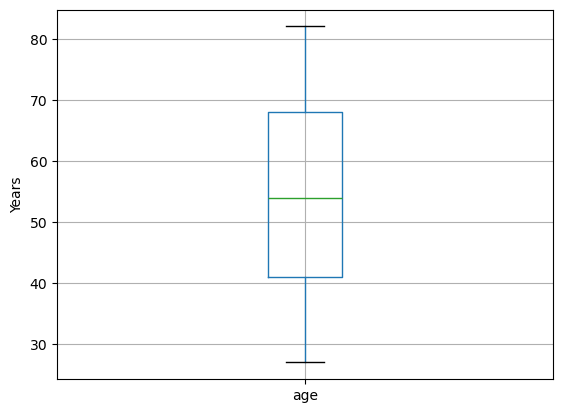

In [21]:
query_age = '''
                SELECT STRFTIME("%Y",dod) - STRFTIME("%Y",dob) as age
                FROM patient
                '''
df_age = pd.read_sql_query(query_age, con)
df_age.boxplot()
plt.ylabel("Years")
plt.show()

*Is DOD earlier than biomarker test date?*

In [22]:
cur.execute('''
                SELECT p.dob, p.dod, b.test_date
                FROM patient as p LEFT JOIN biomarker as b on p.patient_id = b.patient_id
                WHERE p.patient_id IN (
                                        SELECT patient_id
                                        FROM diagnosis
                                        WHERE diagnosis_code LIKE "C50%"
                                        )

            ''')
cur.fetchmany(5)

[('1966-07-20 00:00:00', '2042-06-15 00:00:00', '2018-03-10 00:00:00'),
 ('1930-08-24 00:00:00', '1970-06-04 00:00:00', '1987-11-09 00:00:00'),
 ('1963-04-30 00:00:00', '2036-01-19 00:00:00', '1983-03-01 00:00:00'),
 ('1963-04-30 00:00:00', '2036-01-19 00:00:00', '1996-12-12 00:00:00'),
 ('1963-04-30 00:00:00', '2036-01-19 00:00:00', '1999-08-31 00:00:00')]

### Data maturity 
    - Calculate the summary statistics and plot the distribution of follow up time for BC patients.
    - Calculate the summary statistics and plot the distribution of age at initial diagnosis for BC patients

In [106]:
query_survival= '''
                SELECT p.patient_id, date(p.dod) as dod, p.gender, STRFTIME("%Y", MIN(d.diagnosis_date)) - STRFTIME("%Y",p.dob) as age_at_diagnosis, date(MIN(d.diagnosis_date)) as first_diagnosis_date, date(MAX(d.diagnosis_date)) as last_diagnosis_date, date(MAX(b.test_date)) as last_test_date
                FROM patient as p LEFT JOIN diagnosis as d ON p.patient_id = d.patient_id LEFT JOIN biomarker as b ON p.patient_id = b.patient_id
                GROUP BY p.patient_id        
                HAVING d.diagnosis_code LIKE "C50%"
                '''

df = pd.read_sql_query(query_survival, con)
print(f"Size of the table: {df.shape[0]} x {df.shape[1]}")
df.head()

Size of the table: 795 x 7


,patient_id,dod,gender,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date
0,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,male,50,1993-04-07,2019-05-20,2004-12-19
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,NULL,21,1986-06-02,2021-10-13,2023-12-29
2,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,female,30,1996-10-05,2020-06-13,2018-03-10
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,NULL,26,1977-01-16,1981-10-28,1995-12-08
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,male,26,1956-06-03,2005-01-07,2021-07-29


In [107]:
time_format_cols = ["first_diagnosis_date", "last_diagnosis_date", "last_test_date"]
for col in time_format_cols:
    df[col] = pd.to_datetime(df[col])

def cal_last_encounter(row):
    if row["last_diagnosis_date"] > row["last_test_date"]:
        return row["last_diagnosis_date"]
    else:
        return row["last_test_date"]


df["last_encounter_date"] = df.apply(cal_last_encounter, axis = 1)
df.head()

,patient_id,dod,gender,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date
0,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,male,50,1993-04-07,2019-05-20,2004-12-19,2019-05-20
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,NULL,21,1986-06-02,2021-10-13,2023-12-29,2023-12-29
2,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,female,30,1996-10-05,2020-06-13,2018-03-10,2020-06-13
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,NULL,26,1977-01-16,1981-10-28,1995-12-08,1995-12-08
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,male,26,1956-06-03,2005-01-07,2021-07-29,2021-07-29


In [108]:
df["follow_up_time"] = ((df["last_encounter_date"] - df["first_diagnosis_date"]).dt.days/365.25).round(1)
#patient is event if dod < last_encounter_date while censored if dod > last_encounter_date
df["status"] = (df["dod"] < df["last_encounter_date"]).astype(int)
df.head()

,patient_id,dod,gender,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date,follow_up_time,status
0,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,male,50,1993-04-07,2019-05-20,2004-12-19,2019-05-20,26.1,1
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,NULL,21,1986-06-02,2021-10-13,2023-12-29,2023-12-29,37.6,0
2,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,female,30,1996-10-05,2020-06-13,2018-03-10,2020-06-13,23.7,0
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,NULL,26,1977-01-16,1981-10-28,1995-12-08,1995-12-08,18.9,0
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,male,26,1956-06-03,2005-01-07,2021-07-29,2021-07-29,65.2,1


In [178]:
""" query = '''
        SELECT p.patient_id, STRFTIME("%Y",p.dod) - STRFTIME("%Y", MIN(d.diagnosis_date)) as follow_up_time, STRFTIME("%Y", MIN(d.diagnosis_date)) - STRFTIME("%Y",p.dob) as age_at_diagnosis
        FROM Patient as p LEFT JOIN Diagnosis as d ON p.patient_id = d.patient_id
        GROUP BY p.patient_id 
        HAVING d.diagnosis_code LIKE "C50%"
        '''

df = pd.read_sql_query(query, con)
print(f"Size of the table: {df.shape[0]} x {df.shape[1]}")
df.head() """

Size of the table: 795 x 3


,patient_id,follow_up_time,age_at_diagnosis
0,0022fa14-8260-4b11-88cd-3fa066ede851,15,50
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,52,21
2,019d3689-e49a-4f23-8ca1-65379907230b,46,30
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,30,26
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,48,26


In [179]:
""" df_filter = df[df.follow_up_time > 0]
print(f"Size of the table: {df_filter.shape[0]} x {df_filter.shape[1]}")
df_filter.head() """


Size of the table: 639 x 3


,patient_id,follow_up_time,age_at_diagnosis
0,0022fa14-8260-4b11-88cd-3fa066ede851,15,50
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,52,21
2,019d3689-e49a-4f23-8ca1-65379907230b,46,30
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,30,26
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,48,26


In [109]:
df.isna().sum()

patient_id              0
dod                     0
gender                  0
age_at_diagnosis        0
first_diagnosis_date    0
last_diagnosis_date     0
last_test_date          0
last_encounter_date     0
follow_up_time          0
status                  0
dtype: int64

In [112]:
df[["age_at_diagnosis", "follow_up_time"]].describe()

,age_at_diagnosis,follow_up_time
count,795.000000,795.000000
mean,35.250314,29.546667
std,14.637569,16.296737
min,19.000000,0.000000
25%,24.000000,19.300000
50%,31.000000,29.800000
75%,42.000000,40.500000
max,89.000000,73.700000


In [175]:
fig, axes = plt.subplots(1,2, figsize = (10,5))

p1 = sns.kdeplot(
    df,
    x = "follow_up_time",
    color = "blue",
    ax = axes[0]
)

p2 = sns.kdeplot(
    df,
    x = "age_at_diagnosis",
    ax = axes[1]
)

l1 = p1.lines[0]
l2 = p2.lines[0]

x1, y1 = l1.get_xydata()[:,0], l1.get_xydata()[:,1]
x2, y2 = l2.get_xydata()[:,0], l2.get_xydata()[:,1]
p1.fill_between(x1, y1, color = "blue", alpha = 0.4)
axes[0].axvline(df["follow_up_time"].mean(), c = "k")
axes[0].axvline(df["follow_up_time"].median(), c = "r")


def summary_stats(x):
    plt.axvline(df[x].mean())
    plt.axvline(df[x].median())
    plt.axvline(df[x].quantile(q = 0.95))
    plt.axvlnie(df[x].quantile(q = 0.05))

#axes[1].axvline(df["age_at_diagnosis"].mean(), c = "k")
#axes[1].axvline(df["age_at_diagnosis"].median(), c = "r")

p1.map(summary_stats, "age_at_diagnosis")

plt.show()

AttributeError: 'Axes' object has no attribute 'map'

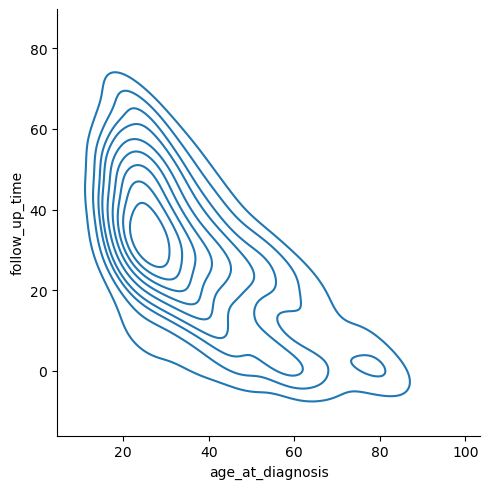

In [170]:
sns.displot(df, x = "age_at_diagnosis", y = "follow_up_time", kind = "kde")
plt.show()

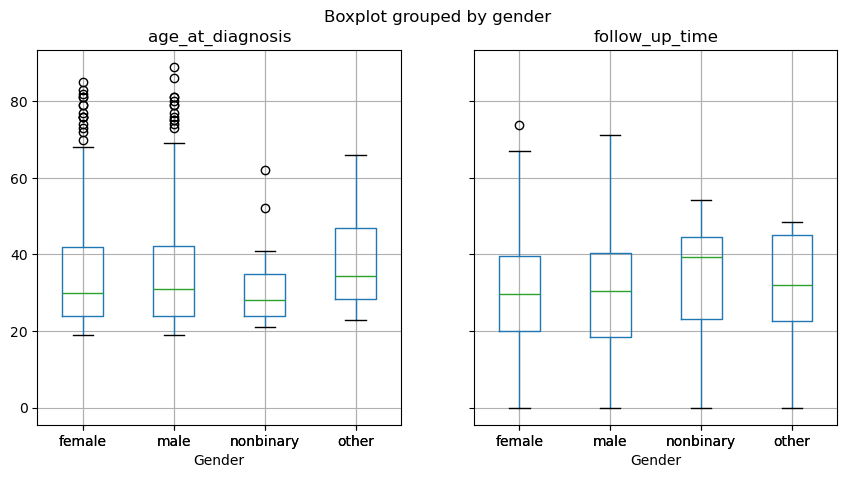

In [145]:
df_removenull = df[df["gender"]!="NULL"]
df_removenull[["follow_up_time", "age_at_diagnosis", "gender"]].boxplot(by = "gender", figsize=(10,5), xlabel = "Gender")
plt.show()

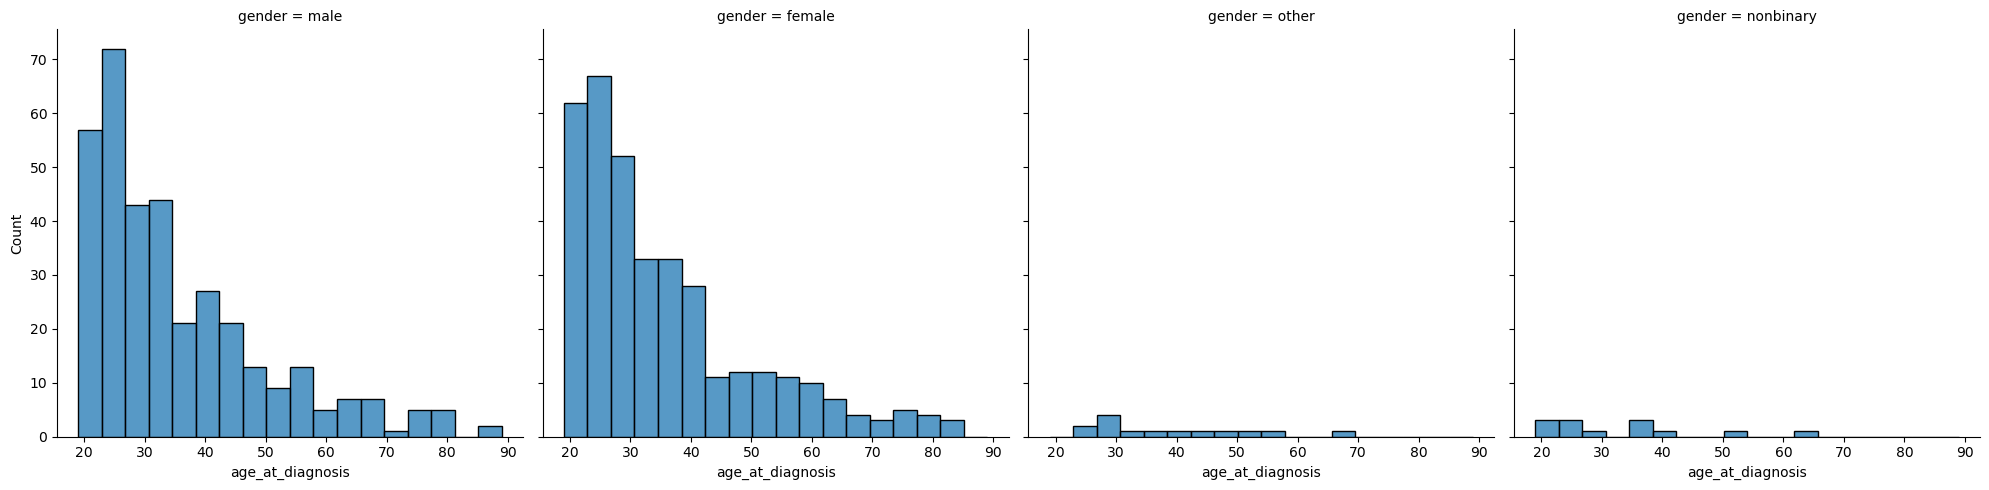

In [146]:
sns.displot(df_removenull, x = "age_at_diagnosis", col = "gender")
plt.show()

### HER2 status
    - Calculate the intent to test rate for HER2. 
    - Calculate the tested rate for HER2.
    - Calculate the negativity rate for HER2.

In [222]:
con = sqlite3.connect("techTest.db")
cur = con.cursor()

### Intent to Test Rate

In [236]:
cur.execute('''
                SELECT AVG(CASE WHEN b.biomarker_name = "HER2" 
                                THEN 1 
                                ELSE 0 
                            END)
                FROM patient as p LEFT JOIN biomarker as b on p.patient_id = b.patient_id
                WHERE p.patient_id IN (
                                        SELECT patient_id
                                        FROM diagnosis
                                        WHERE diagnosis_code LIKE "C50%"
                                        )

            ''')
intent_to_test_rate = cur.fetchone()[0]
print(f"Intent to test rate is {intent_to_test_rate :0.2f}")

Intent to test rate is 0.50


### Tested Rate

In [252]:
cur.execute('''
                SELECT AVG(CASE WHEN (COALESCE(b.biomarker_name,0) = "HER2") AND (COALESCE(b.biomarker_test_type,0) in ("PCR", "IHC")) 
                                THEN 1 
                                ELSE 0 
                            END)
                FROM patient as p LEFT JOIN biomarker as b on p.patient_id = b.patient_id
                WHERE p.patient_id IN (
                                        SELECT patient_id
                                        FROM diagnosis
                                        WHERE diagnosis_code LIKE "C50%"
                                        )

            ''')
test_rate = cur.fetchone()[0]
print(f"Test rate = {test_rate :0.2f}")

Test rate = 0.31


### Negativity Rate

Here, I am assuming that unknown is 0

In [32]:
cur.execute('''
                SELECT AVG(CASE WHEN (b.biomarker_name = "HER2") AND (b.test_result = "Negative") 
                                THEN 1 
                                ELSE 0 
                            END)
                FROM patient as p LEFT JOIN biomarker as b on p.patient_id = b.patient_id
                WHERE p.patient_id IN (
                                        SELECT patient_id
                                        FROM diagnosis
                                        WHERE diagnosis_code LIKE "C50%"
                                        )

            ''')
negative_rate = cur.fetchone()[0]
print(f"Negativity rate = {negative_rate :0.2f}")

Negativity rate = 0.14


### Survival Analysis

In [61]:
""" time_format_cols = ["first_diagnosis_date", "last_diagnosis_date", "last_test_date"]
for col in time_format_cols:
    df_survival[col] = pd.to_datetime(df_survival[col])

def cal_last_encounter(row):
    if row["last_diagnosis_date"] > row["last_test_date"]:
        return row["last_diagnosis_date"]
    else:
        return row["last_test_date"]


df_survival["last_encounter_date"] = df_survival.apply(cal_last_encounter, axis = 1)
df_survival.head() """

,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date
0,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,50,1993-04-07,2019-05-20,2004-12-19,2019-05-20
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,21,1986-06-02,2021-10-13,2023-12-29,2023-12-29
2,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,30,1996-10-05,2020-06-13,2018-03-10,2020-06-13
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,26,1977-01-16,1981-10-28,1995-12-08,1995-12-08
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,26,1956-06-03,2005-01-07,2021-07-29,2021-07-29


In [70]:
""" df_survival["follow_up_time"] = ((df_survival["last_encounter_date"] - df_survival["first_diagnosis_date"]).dt.days/365.25).round(1)
#patient is event if dod < last_encounter_date while censored if dod > last_encounter_date
df_survival["status"] = (df_survival["dod"] < df_survival["last_encounter_date"]).astype(int)
df_survival.head() """

,patient_id,dod,age_at_diagnosis,first_diagnosis_date,last_diagnosis_date,last_test_date,last_encounter_date,follow_up_time,status
0,0022fa14-8260-4b11-88cd-3fa066ede851,2008-03-04,50,1993-04-07,2019-05-20,2004-12-19,2019-05-20,26.1,1
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,2038-03-11,21,1986-06-02,2021-10-13,2023-12-29,2023-12-29,37.6,0
2,019d3689-e49a-4f23-8ca1-65379907230b,2042-06-15,30,1996-10-05,2020-06-13,2018-03-10,2020-06-13,23.7,0
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,2007-07-30,26,1977-01-16,1981-10-28,1995-12-08,1995-12-08,18.9,0
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,2004-02-09,26,1956-06-03,2005-01-07,2021-07-29,2021-07-29,65.2,1


In [137]:
assert (df["follow_up_time"] < 0).sum() == 0

df.isna().sum()

patient_id              0
dod                     0
gender                  0
age_at_diagnosis        0
first_diagnosis_date    0
last_diagnosis_date     0
last_test_date          0
last_encounter_date     0
follow_up_time          0
status                  0
dtype: int64

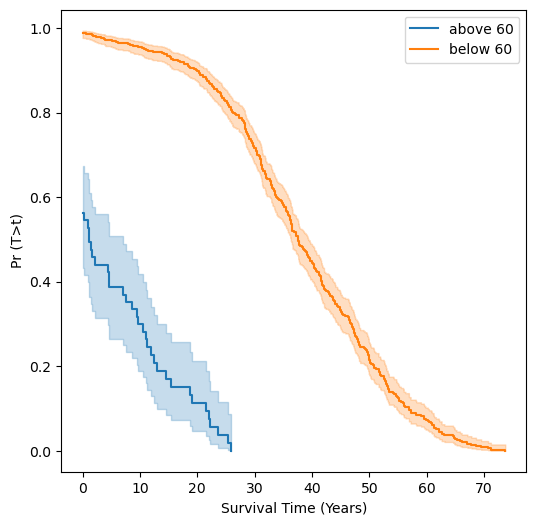

In [138]:

stratify_age = 60
mask = df["age_at_diagnosis"] > stratify_age
fig, axes = plt.subplots(figsize = (6,6))

km = KaplanMeierFitter()
km_lowerage = km.fit(df.loc[mask,"follow_up_time"], df.loc[mask,"status"])
km_lowerage.plot(label = f"above {stratify_age}")
km_upperage = km.fit(df.loc[~mask,"follow_up_time"], df.loc[~mask,"status"])
km_upperage.plot(label = f"below {stratify_age}", xlabel = "Survival Time (Years)", ylabel = "Pr (T>t)")
plt.show()

In [132]:
stats_results = logrank_test(df.loc[mask,"follow_up_time"], df.loc[~mask,"follow_up_time"], df.loc[mask,"status"], df.loc[~mask,"status"])

print(stats_results)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         580.79 <0.005    423.87


In [33]:
cur.execute('''
                SELECT *
                FROM diagnosis
                

''')

for item in cur.fetchmany(10):
    print(item)

('019d3689-e49a-4f23-8ca1-65379907230b', '2020-06-13 00:00:00', 'C50', 'icd10')
('019d3689-e49a-4f23-8ca1-65379907230b', '1996-10-05 00:00:00', 'C50.4', 'icd10')
('019d3689-e49a-4f23-8ca1-65379907230b', '2004-10-30 00:00:00', 'C50.4', 'icd10')
('81de4975-519f-48c6-a5fa-a57d891495a6', '1986-04-01 00:00:00', 'C50', 'icd10')
('dbed4b3e-33ba-4856-a78d-3db6d211def8', '1997-12-21 00:00:00', 'C51', 'icd10')
('dbed4b3e-33ba-4856-a78d-3db6d211def8', '1995-04-24 00:00:00', 'J18.9', 'icd10')
('dbed4b3e-33ba-4856-a78d-3db6d211def8', '2017-06-08 00:00:00', 'C50.2', 'icd10')
('dbed4b3e-33ba-4856-a78d-3db6d211def8', '2016-06-30 00:00:00', 'C50.49', 'icd10')
('dbed4b3e-33ba-4856-a78d-3db6d211def8', '1993-09-08 00:00:00', 'I10', 'icd10')
('32808df0-103c-409e-ad6b-60ec55d60612', '1968-08-20 00:00:00', 'C50.2', 'icd10')
